<a href="https://colab.research.google.com/github/RishitSingh10/BitPredict/blob/main/time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series Forcasting Fundamentals with TensorFlow + Project: BitPredict

Project to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note:** This is not a financial advice.

## Get Data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://finance.yahoo.com/quote/BTC-INR/history/

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/RishitSingh10/BitPredict/main/BTC_INR_17-09-2014_TO_06-11-2023.csv', parse_dates = ['Date'], index_col = ['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,28443.328125,28542.228516,27552.500000,27851.640625,27851.640625,1282359120
2014-09-18,27822.773438,27822.773438,25085.740234,25774.119141,25774.119141,2093992320
2014-09-19,25753.654297,25988.835938,23366.087891,24023.335938,24023.335938,2307413745
2014-09-20,24015.851563,25757.560547,23724.380859,24881.808594,24881.808594,2243150060
2014-09-21,24831.972656,25096.121094,23925.064453,24268.257813,24268.257813,1617399085


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3338 entries, 2014-09-17 to 2023-11-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3338 non-null   float64
 1   High       3338 non-null   float64
 2   Low        3338 non-null   float64
 3   Close      3338 non-null   float64
 4   Adj Close  3338 non-null   float64
 5   Volume     3338 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 182.5 KB


In [3]:
# How many samples do we have
len(df)

3338

We've collected the historical price of Bitcoin for the past ~9 years but there's only 3338 samples.

**Note:** The **seasonality** of our time series dataset is 365. Seasonality is reffered to as the number of samples per year.

In [4]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Close']).rename(columns = {"Close":"Price"})
bitcoin_prices.head()

,Price
Date,
2014-09-17,27851.640625
2014-09-18,25774.119141
2014-09-19,24023.335938
2014-09-20,24881.808594
2014-09-21,24268.257813


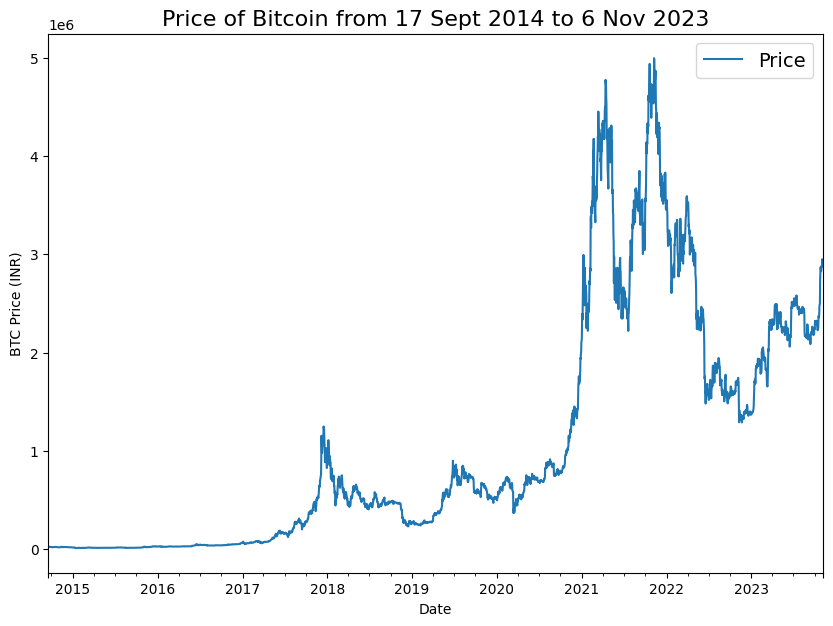

In [5]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize = (10,7))
plt.ylabel('BTC Price (INR)')
plt.title("Price of Bitcoin from 17 Sept 2014 to 6 Nov 2023", fontsize = 16)
plt.legend(fontsize = 14)

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [6]:
bitcoin_prices[:5]

,Price
Date,
2014-09-17,27851.640625
2014-09-18,25774.119141
2014-09-19,24023.335938
2014-09-20,24881.808594
2014-09-21,24268.257813


In [7]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([27851.640625, 25774.119141, 24023.335938, 24881.808594,
        24268.257813, 24503.121094, 26600.681641, 25785.878906,
        25241.833984, 24726.542969]))

In [8]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size = .2,
                                                    random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2670,), (668,), (2670,), (668,))

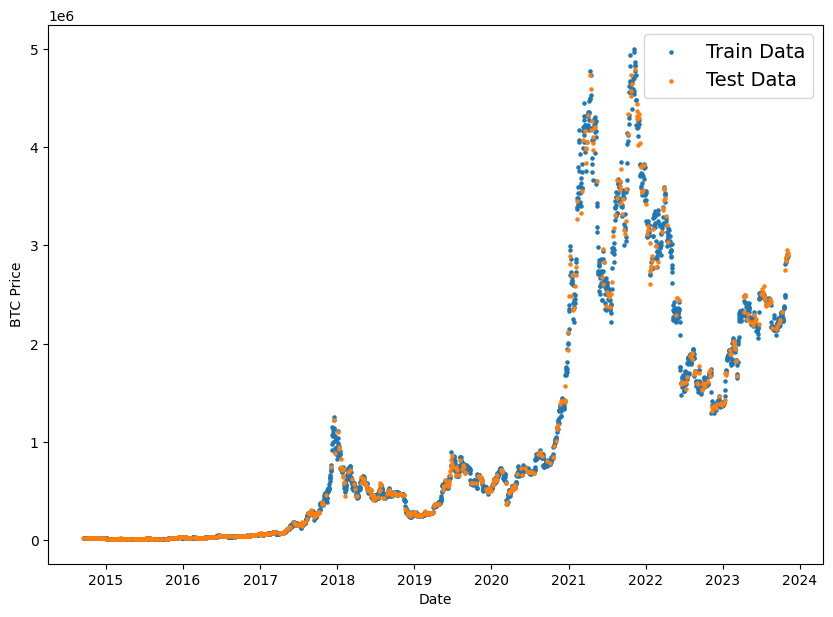

In [9]:
# Let's plot wrong train and test splits
plt.figure(figsize = (10,7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize = 14)
plt.show()

### Create train & test sets for time series (the right way)

In [10]:
# Create train and test splits the right way for time series data
split_size = int(.8 * len(prices)) # 80% train, 20% test

# Create train data split (everything before split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2670, 668, 2670, 668)

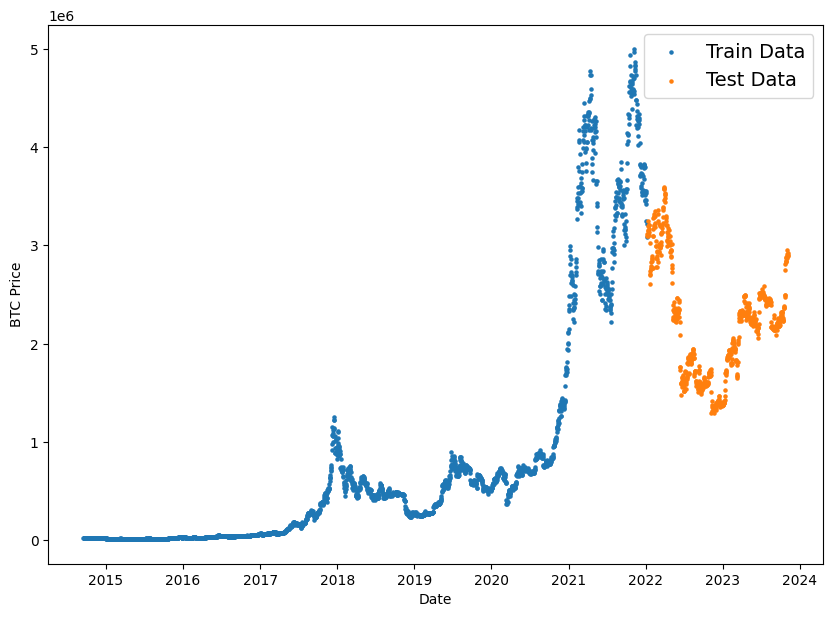

In [11]:
# Plot correctly made splits
plt.figure(figsize = (10,7))
plt.scatter(X_train, y_train, s = 5, label = "Train Data")
plt.scatter(X_test, y_test, s = 5, label = "Test Data")
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize = 14)
plt.show()

## Create a plotting function
Typing plotting code is tedious, let's functionize it.

In [12]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start = 0, end = None, label = None):
  '''
  Plots timesteps (a series of points in time) against values (a series of values across timesteps)

  Parameters
  ----------
  timesteps : array of timestep values
  values :  array of value across time
  format :  style of plot, default "."
  start : where to start the plot (setting a valu will index from start of timesteps & values)
  end :  where to end the plot (similar to start but for the end)
  label : label to show on plot values, default None
  '''
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format , label = label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize = 14) # make label bigger
  plt.grid(True)

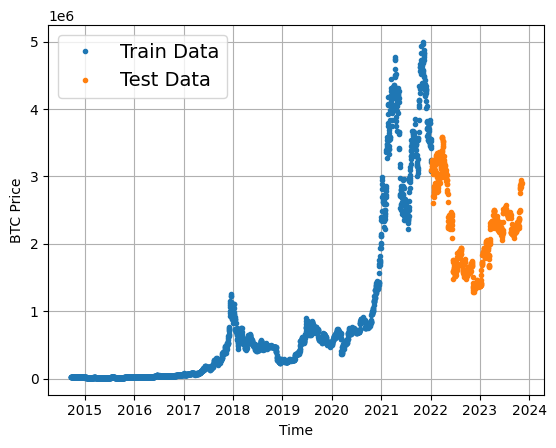

In [13]:
# Test out plotting function
plot_time_series(timesteps = X_train, values=y_train, label = "Train Data")
plot_time_series(timesteps = X_test, values = y_test, label = "Test Data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Modelling experiments we're running:

* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Same as 1, horizon = 1, window = 30
* 3 Same as 1, horizon = 7, window = 30
* 4 Conv 1D
* 5 LSTM
* 6 Same as 1 (but with multivariate data)
* 7 N-BEATs Algorithm
* 8 Ensemble
* 9 Future Prediction (model to predict future values)





## Model 0: Naive Forecast (basline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In [14]:
# Create a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([3098125.5 , 3112181.75, 3097138.5 , 3154570.  , 3243415.  ,
        3150603.  , 3196112.  , 3201873.75, 3202534.5 , 3137342.5 ]),
 array([2844666.5 , 2828638.5 , 2843634.75, 2880921.25, 2872237.5 ,
        2887054.5 , 2950284.25, 2908174.25, 2888296.5 , 2917391.5 ]))

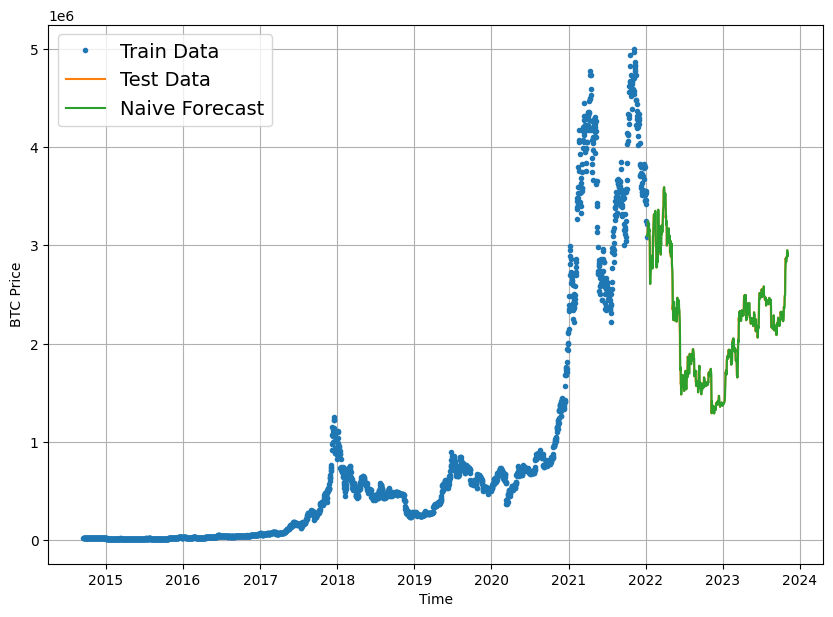

In [15]:
# Plot naive forecast
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_train, values = y_train, label = 'Train Data')
plot_time_series(timesteps = X_test, values =y_test,format='-', label = 'Test Data')
plot_time_series(timesteps = X_test[1:], values = naive_forecast,format = "-", label = 'Naive Forecast')

## Evaluating a time series model

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print(f"MSE: {mean_squared_error(y_test[1:], naive_forecast)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test[1:], naive_forecast))}")
print(f"MAE: {mean_absolute_error(y_test[1:], naive_forecast)}")
print(f"MAE %: {mean_absolute_percentage_error(y_test[1:], naive_forecast)}")

MSE: 4190112456.1007776
RMSE: 64731.07797728057
MAE: 41211.637931034486
MAE %: 0.018752186086509588


In [17]:
import tensorflow as tf

# MASE - mean absolute scaled error
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is one day

  return mae/mae_naive_no_season

In [18]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true = y_test[1:], y_pred = naive_forecast).numpy()

0.9990116006801483

In [19]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}

In [20]:
naive_results = evaluate_preds(y_true = y_test[1:],
                               y_pred = naive_forecast)
naive_results

{'mae': 41211.64,
 'mse': 4190112500.0,
 'rmse': 64731.08,
 'mape': 1.8752187,
 'mase': 0.9990117}

In [21]:
naive_forecast[-10:]

array([2844666.5 , 2828638.5 , 2843634.75, 2880921.25, 2872237.5 ,
       2887054.5 , 2950284.25, 2908174.25, 2888296.5 , 2917391.5 ])

 ## Format Data Part 2: Windowing our dataset

 Why do we window?
 We window our time series dataset to turn our data into a supervised learning problems

 ```
 Windowing for one week
 [0, 1, 2, 3, 4, 5, 6] -> [7]
 [1, 2, 3, 4, 5, 6, 7] -> [8]
 [2, 3, 4, 5, 6, 7, 8] -> [9]


In [22]:
len(y_train)

2670

In [23]:
# What we want to do with our Bitcoin data
print(f"We want to use: {prices[:7]} to predict: {prices[7]}")

We want to use: [27851.640625 25774.119141 24023.335938 24881.808594 24268.257813
 24503.121094 26600.681641] to predict: 25785.878906


In [24]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict next 1 daya
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make prediction

In [25]:
# Create function to label windowed data
def get_labelled_windows(x, horizon = HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon = 1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [26]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis = 0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label:{tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label:7


We've got a way to label our windowed data. We need a way to do the above across our entire time series.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses out `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.

In [27]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon at the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis = 0).T # create 2D array of windows of size window_size
  #print(f"Window indexes:\n{window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [28]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(3331, 3331)

In [29]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [27851.640625 25774.119141 24023.335938 24881.808594 24268.257813
 24503.121094 26600.681641] -> Label: [25785.878906]
Window: [25774.119141 24023.335938 24881.808594 24268.257813 24503.121094
 26600.681641 25785.878906] -> Label: [25241.833984]
Window: [24023.335938 24881.808594 24268.257813 24503.121094 26600.681641
 25785.878906 25241.833984] -> Label: [24726.542969]


In [30]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [2828638.5  2843634.75 2880921.25 2872237.5  2887054.5  2950284.25
 2908174.25] -> Label: [2888296.5]
Window: [2843634.75 2880921.25 2872237.5  2887054.5  2950284.25 2908174.25
 2888296.5 ] -> Label: [2917391.5]
Window: [2880921.25 2872237.5  2887054.5  2950284.25 2908174.25 2888296.5
 2917391.5 ] -> Label: [2899827.]


In [31]:
prices[-1]

2899827.0

## Turning windows into training and test sets

In [32]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split = .2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2664, 667, 2664, 667)

In [34]:
# Check to see if train labels are the same (before and after window split)
y_train[7:] ==  np.squeeze(train_labels[:-1])

array([ True,  True,  True, ...,  True,  True,  True])

## Making a modelling checkpoint callback

In [35]:
import os

# Create a function to implement a ModelCheckpoint callback
def create_model_checkpoint(model_name, save_path = "model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                            verbose = 0,
                                            save_best_only = True)

## Model 1: Dense Model (window = 7, horizon = 1)

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(HORIZON, activation = 'linear')
], name = 'model_1_dense')

model_1.compile(loss = 'mae',
                optimizer = 'adam',
                metrics = ['mae', 'mse'])

model_1.fit(x = train_windows,
            y = train_labels,
            epochs = 100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
21/21 [==============================] - 3s 41ms/step - loss: 236419.6562 - mae: 236419.6562 - mse: 286026530816.0000 - val_loss: 241571.1250 - val_mae: 241571.1250 - val_mse: 74251575296.0000
Epoch 2/100
21/21 [==============================] - 0s 23ms/step - loss: 51509.3438 - mae: 51509.3438 - mse: 12967290880.0000 - val_loss: 79570.7344 - val_mae: 79570.7344 - val_mse: 12912185344.0000
Epoch 3/100
21/21 [==============================] - 0s 23ms/step - loss: 37473.6836 - mae: 37473.6836 - mse: 7321129472.0000 - val_loss: 64606.8828 - val_mae: 64606.8828 - val_mse: 9414225920.0000
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 34488.0938 - mae: 34488.0938 - mse: 6213341184.0000 - val_loss: 68819.6016 - val_mae: 68819.6016 - val_mse: 9782802432.0000
Epoch 5/100
21/21 [==============================] - 0s 23ms/step - loss: 33541.5273 - mae: 33541.5273 - mse: 5915104256.0000 - val_loss: 59141.2305 - val_mae: 59141.2305 - val_mse: 8041869824.0000
Ep

In [37]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 49475.7227 - mae: 49475.7227 - mse: 5003895296.0000


[49475.72265625, 49475.72265625, 5003895296.0]

In [38]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model('/content/model_experiments/model_1_dense/')
model_1.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 2ms/step - loss: 42160.6562 - mae: 42160.6562 - mse: 4363355136.0000


[42160.65625, 42160.65625, 4363355136.0]

## Making forecast with a model (on the test dataset)

In [39]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [40]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

21/21 [==============================] - 0s 2ms/step


(667,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([3068973.8, 3095991. , 3085901.5, 3137601.8, 3230222.5, 3169638.2,
        3185324.5, 3208285.8, 3197487.5, 3146223. ], dtype=float32)>)

In [41]:
# Evaluate preds
model_1_results = evaluate_preds(y_true = np.squeeze(test_labels),
                               y_pred = model_1_preds)
model_1_results

{'mae': 42160.652,
 'mse': 4363354600.0,
 'rmse': 66055.695,
 'mape': 1.9161446,
 'mase': 1.0220168}

In [42]:
naive_results

{'mae': 41211.64,
 'mse': 4190112500.0,
 'rmse': 64731.08,
 'mape': 1.8752187,
 'mase': 0.9990117}

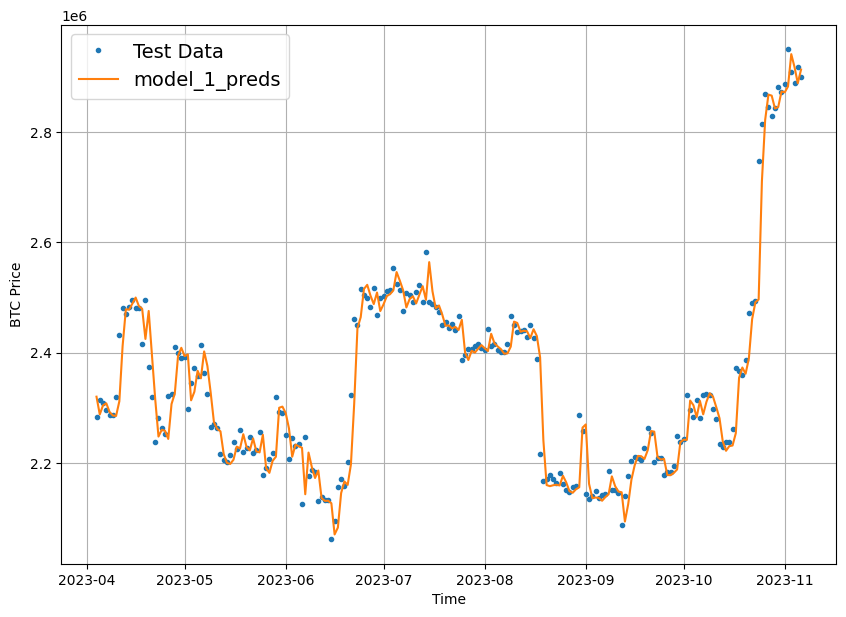

In [43]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize = (10,7))
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = test_labels[:, 0],
                 start = offset,
                 label = 'Test Data')
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = model_1_preds,
                 start = offset,
                 format = '-',
                 label = 'model_1_preds')

## Model 2: Dense (window = 30, horizon = 1)

In [44]:
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [45]:
#  Make windows data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(3308, 3308)

In [46]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows,
                                                                               labels = full_labels,
                                                                               test_split = .2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2646, 662, 2646, 662)

In [47]:
train_windows[:3], train_labels[:3]

(array([[27851.640625, 25774.119141, 24023.335938, 24881.808594,
         24268.257813, 24503.121094, 26600.681641, 25785.878906,
         25241.833984, 24726.542969, 24426.652344, 23060.845703,
         23108.117188, 23961.507813, 23672.880859, 23080.054688,
         22122.570313, 20236.769531, 19722.583984, 20311.412109,
         20604.902344, 21652.869141, 22281.1875  , 22152.904297,
         22198.060547, 23193.697266, 23813.302734, 24607.404297,
         24227.21875 , 23611.355469],
        [25774.119141, 24023.335938, 24881.808594, 24268.257813,
         24503.121094, 26600.681641, 25785.878906, 25241.833984,
         24726.542969, 24426.652344, 23060.845703, 23108.117188,
         23961.507813, 23672.880859, 23080.054688, 22122.570313,
         20236.769531, 19722.583984, 20311.412109, 20604.902344,
         21652.869141, 22281.1875  , 22152.904297, 22198.060547,
         23193.697266, 23813.302734, 24607.404297, 24227.21875 ,
         23611.355469, 23543.552734],
        [24023

In [48]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(HORIZON)
], name = 'model_2_dense')

# Compile
model_2.compile(loss = 'mae',
                optimizer = 'adam',
                metrics = ['mae', 'mse'])

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])


In [49]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 6ms/step - loss: 47520.5781 - mae: 47520.5781 - mse: 4968098304.0000


[47520.578125, 47520.578125, 4968098304.0]

In [50]:
# Load in the best performing model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 5ms/step - loss: 45843.0430 - mae: 45843.0430 - mse: 4831118848.0000


[45843.04296875, 45843.04296875, 4831118848.0]

In [51]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data = test_windows)

21/21 [==============================] - 0s 2ms/step


In [52]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 45843.043,
 'mse': 4831118000.0,
 'rmse': 69506.24,
 'mape': 2.097843,
 'mase': 1.1151001}

In [53]:
model_1_results

{'mae': 42160.652,
 'mse': 4363354600.0,
 'rmse': 66055.695,
 'mape': 1.9161446,
 'mase': 1.0220168}

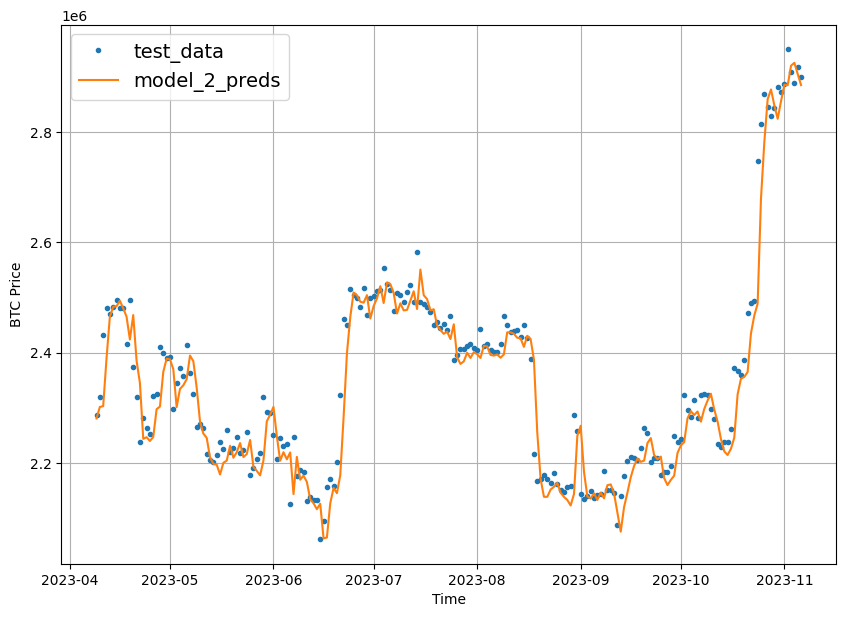

In [54]:
offset = 450
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = 'test_data')
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_2_preds, start = offset, format = '-', label = 'model_2_preds')

## Model 3 (window = 30, horizon = 7)

In [55]:
WINDOW_SIZE = 30
HORIZON = 7

In [56]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(3302, 3302)

In [57]:
# Make train test split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2641, 661, 2641, 661)

In [58]:
train_windows[:3], train_labels[:3]

(array([[27851.640625, 25774.119141, 24023.335938, 24881.808594,
         24268.257813, 24503.121094, 26600.681641, 25785.878906,
         25241.833984, 24726.542969, 24426.652344, 23060.845703,
         23108.117188, 23961.507813, 23672.880859, 23080.054688,
         22122.570313, 20236.769531, 19722.583984, 20311.412109,
         20604.902344, 21652.869141, 22281.1875  , 22152.904297,
         22198.060547, 23193.697266, 23813.302734, 24607.404297,
         24227.21875 , 23611.355469],
        [25774.119141, 24023.335938, 24881.808594, 24268.257813,
         24503.121094, 26600.681641, 25785.878906, 25241.833984,
         24726.542969, 24426.652344, 23060.845703, 23108.117188,
         23961.507813, 23672.880859, 23080.054688, 22122.570313,
         20236.769531, 19722.583984, 20311.412109, 20604.902344,
         21652.869141, 22281.1875  , 22152.904297, 22198.060547,
         23193.697266, 23813.302734, 24607.404297, 24227.21875 ,
         23611.355469, 23543.552734],
        [24023

In [59]:
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation = 'relu'),
    layers.Dense(HORIZON)
], name = 'model_3_dense')

# Compile
model_3.compile(loss = 'mae',
                optimizer = 'adam',
                metrics = ['mae', 'mse'])

# Fit
model_3.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_3.name)])


In [60]:
# Evaluate model 2 on test data
model_3.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 6ms/step - loss: 99543.8828 - mae: 99543.8828 - mse: 21630732288.0000


[99543.8828125, 99543.8828125, 21630732288.0]

In [61]:
# Load in the best performing model
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

21/21 [==============================] - 0s 4ms/step - loss: 95879.7812 - mae: 95879.7812 - mse: 20841807872.0000


[95879.78125, 95879.78125, 20841807872.0]

In [62]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data = test_windows)

21/21 [==============================] - 0s 2ms/step


In [63]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': array([ 72209.93 , 118607.32 , 103478.29 ,  47289.57 ,  46366.   ,
         41595.605, 128700.21 , 188610.25 , 277433.22 , 303504.6  ,
        367250.84 , 378317.84 , 327950.97 ,  99936.79 , 144894.17 ,
        203610.97 , 167635.25 , 145047.39 , 117778.71 ,  84593.46 ,
         79667.89 , 124115.07 , 195364.22 , 210290.17 , 251920.86 ,
        327714.22 , 394552.5  , 239246.14 , 206002.5  ,  96937.36 ,
         40986.715,  77505.39 ,  87931.71 , 150680.03 , 130886.89 ,
        121891.86 , 141388.08 , 213501.03 , 316855.16 , 438891.84 ,
        305712.53 , 189436.22 , 117342.75 ,  66472.39 , 113806.5  ,
        200523.14 , 263566.28 , 251001.25 , 243719.03 , 262429.53 ,
        256968.72 , 171321.47 , 216544.28 , 357402.44 , 329014.16 ,
        179408.75 , 129441.29 ,  70982.89 , 122158.54 , 144867.36 ,
        123604.36 ,  90879.04 , 105790.21 , 183160.78 , 238650.17 ,
        209402.86 , 219296.03 , 138470.14 , 101927.07 ,  79814.32 ,
        107243.29 , 140072.14 , 257384.14

## Making the evaluation function work for larger horizons

In [64]:
model_3_results['mae'].shape, model_2_results['mae'].shape

((661,), ())

In [65]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype = tf.float32)
  y_pred = tf.cast(y_pred, dtype = tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}

In [66]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(tf.squeeze(test_labels),
                                 model_3_preds)
model_3_results

{'mae': 95879.77,
 'mse': 20841806000.0,
 'rmse': 110501.07,
 'mape': 4.4073296,
 'mase': 2.3238976}

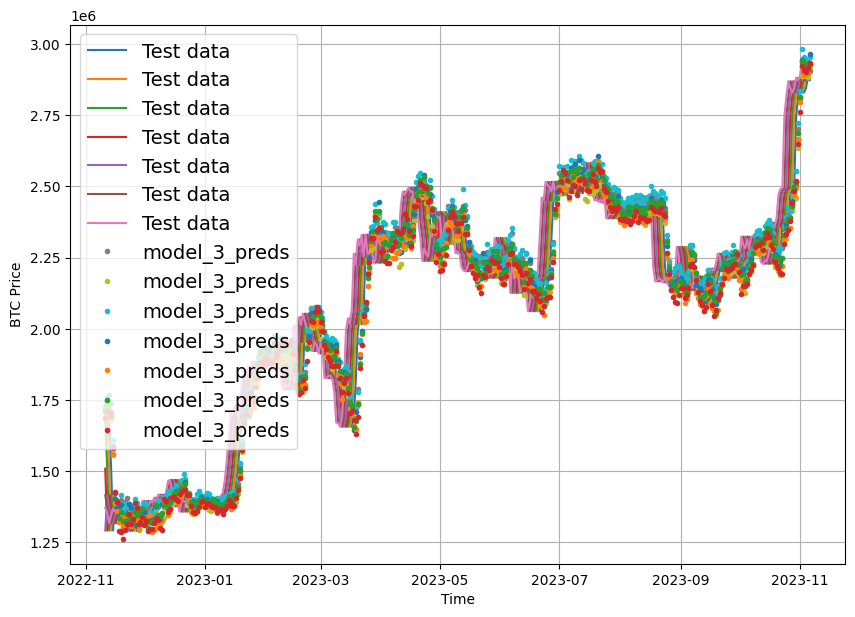

In [67]:
# Visualising the model 3 predictions

offset = 300
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):],format = '-',
                 values = test_labels[:,], start = offset, label = "Test data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_3_preds, start = offset, label = "model_3_preds")

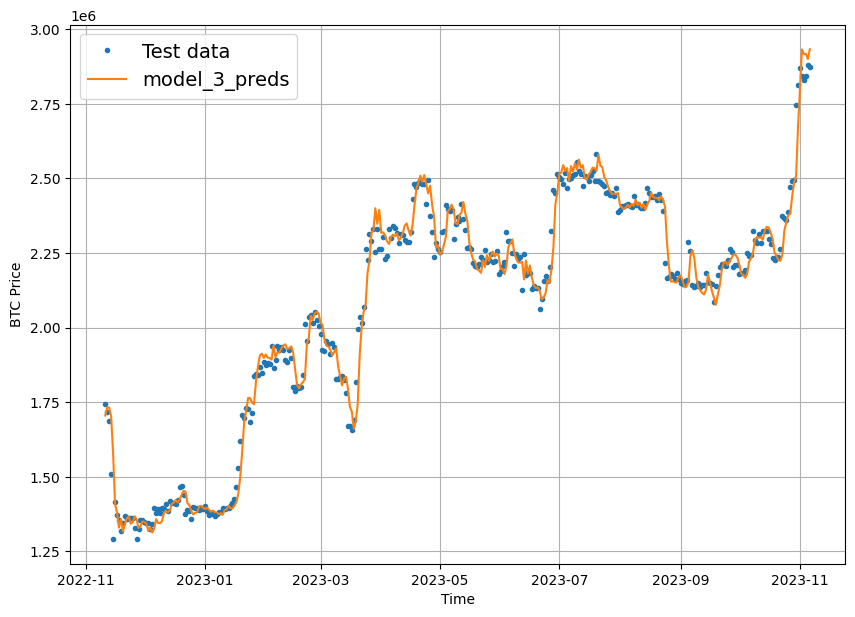

In [68]:
# Visualising the model 3 predictions

offset = 300
plt.figure(figsize = (10, 7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = "Test data")
plot_time_series(timesteps = X_test[-len(test_windows):],
                 values = tf.reduce_mean(model_3_preds, axis = 1),
                 start = offset,
                 format = '-',
                 label = "model_3_preds")

## Comparing the models

<Axes: >

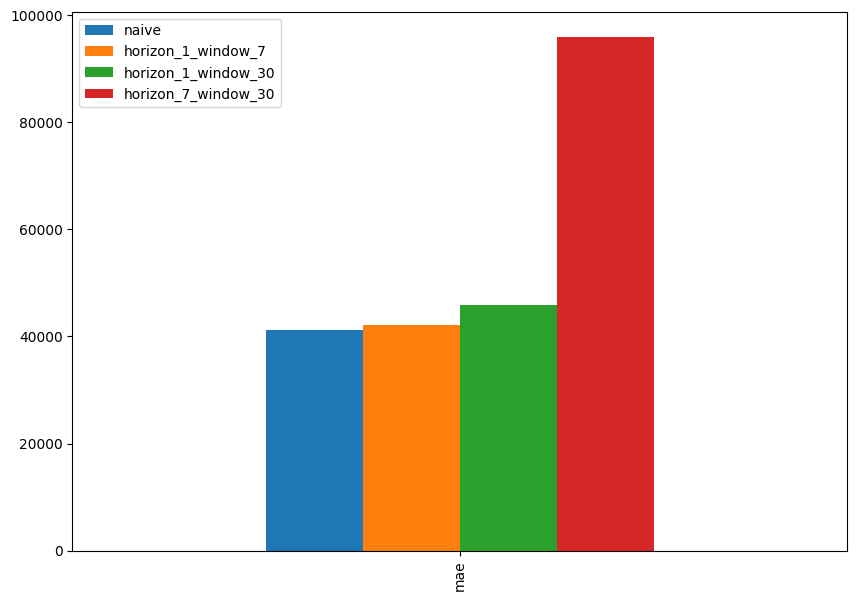

In [70]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]},index = ["mae"]).plot(figsize = (10, 7), kind = "bar")